**This line installs TensorFlow version 2.12 using pip**

In [1]:
!pip install tensorflow==2.12

**Dataset**

**# Download and unzip the Jena climate dataset for analysis**

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-03 20:06:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.86, 52.217.95.0, 52.216.44.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  37.0MB/s    in 0.3s    

2024-11-03 20:06:06 (37.0 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Load the Jena climate dataset, extract header and data rows, and print the number of variables and rows**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_var = len(header1)
print("Number of variables:", num_var)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Dataset contains 420451 rows and 15 features**

**After analyzing the data, specific values are stored in the `raw_data` and `temperature` arrays for further processing or analysis. The comma-separated values are converted to floating-point numbers.**

In [4]:
import numpy as np
temp1 = np.zeros((len(line1),))
raw_d = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    raw_d[i, :] = values[:]

**The plot of temperature over time.**

Text(0, 0.5, 'Temperature')

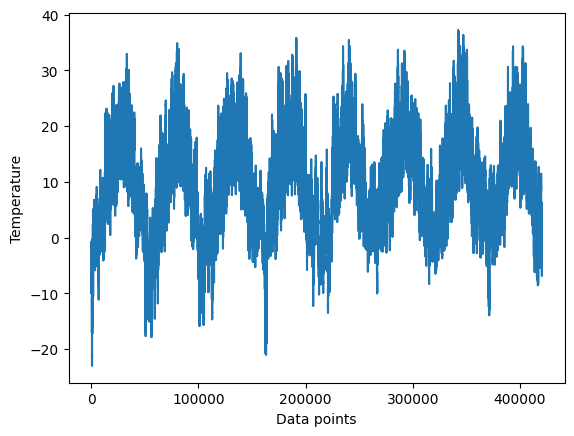

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**The temperature time series for the first ten days is plotted, with each day containing 144 data points, resulting in a total of 1,440 data points.**

Text(0, 0.5, 'Temperature')

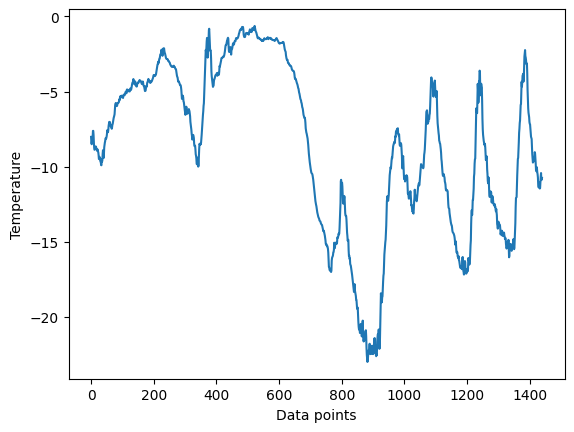

In [6]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Determining the required number of samples for each data split, with 25% reserved for validation and 50% for training.**

In [7]:
num_of_train = int(0.5 * len(raw_d))
num_of_val= int(0.25 * len(raw_d))
num_of_test= len(raw_d) - num_of_train - num_of_val
print("Number of train samples:", num_of_train)
print("Number of validation samples:", num_of_val)
print("Number of test samples:", num_of_test)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


**Getting the information ready**

**Vectorization isn't needed since the data is already numerical. However, standardizing all variables is essential due to differing scales (e.g., temperature ranges from -20 to +30, while pressure is measured in millibars).**

In [8]:
mean1 = raw_d[:num_of_train].mean(axis=0)
raw_d -= mean1
std = raw_d[:num_of_train].std(axis=0)
raw_d /= std

**Creating separate training, validation, and testing datasets is crucial due to extensive duplication within the data. Allocating RAM for each sample would be inefficient, so samples will be generated dynamically in real-time.**

In [9]:
!pip install tensorflow
import tensorflow as tf
import keras

sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

# Now you can use keras.utils.timeseries_dataset_from_array
training_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_of_train)

validation_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train,
    end_index=num_of_train + num_of_val)

testing_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train + num_of_val)

**Result of the databases**

In [10]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A practical baseline that doesn't rely on machine learning: To establish the baseline Mean Absolute Error (MAE), the last value in the input sequence is used as the initial point. The function "evaluate_naive_method" is created for this purpose, serving as a reference for assessing the performance of a straightforward forecasting method.**

In [11]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**A simple method is to forecast that the temperature will remain constant for the next 24 hours. With this basic baseline, the test mean is 2.62 degrees Celsius, while the validation mean absolute error (MAE) is 2.44 degrees. This means that if future temperatures were to remain unchanged, the average deviation from the actual temperature would be about 2.5 degrees.**

**Introduction to Machine Learning: Dense Layer**

**This section covers the training and evaluation of a densely connected model.**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

**# Set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model with training and validation data for 5 epochs while saving the best model.**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=5,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 51s 61ms/step - loss: 12.0776 - mae: 2.6928 - val_loss: 11.6513 - val_mae: 2.6952
Epoch 2/5
819/819 [==============================] - 50s 60ms/step - loss: 8.9123 - mae: 2.3452 - val_loss: 11.3207 - val_mae: 2.6531
Epoch 3/5
819/819 [==============================] - 56s 68ms/step - loss: 8.2088 - mae: 2.2524 - val_loss: 10.6695 - val_mae: 2.5718
Epoch 4/5
819/819 [==============================] - 52s 63ms/step - loss: 7.8063 - mae: 2.1952 - val_loss: 10.7516 - val_mae: 2.5985
Epoch 5/5
819/819 [==============================] - 54s 65ms/step - loss: 7.5022 - mae: 2.1536 - val_loss: 11.2950 - val_mae: 2.6525


**# Load the trained model and evaluate its performance on the testing data, printing the test MAE.**

In [14]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 17s 40ms/step - loss: 11.6700 - mae: 2.6934
Test MAE: 2.69


**# Plot the training and validation Mean Absolute Error (MAE) over the epochs to visualize model performance.**

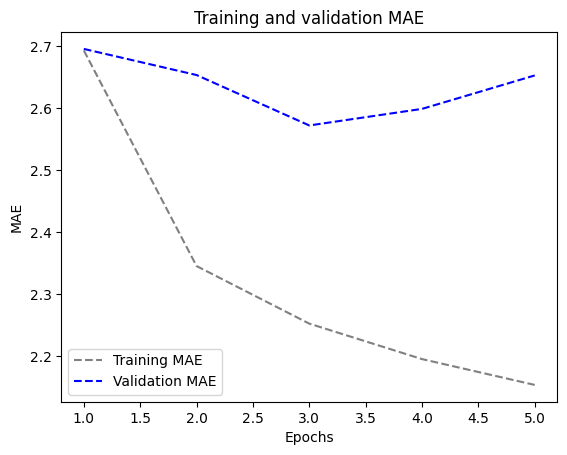

In [15]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D convolutional model.**

**# Define a 1D Convolutional Neural Network model with Conv1D and MaxPooling layers, culminating in a dense output layer.**

In [16]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

**# Set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, fit the model for 5 epochs with training and validation data, and evaluate the test MAE of the loaded model.**

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 95s 113ms/step - loss: 22.7559 - mae: 3.7421 - val_loss: 16.4065 - val_mae: 3.2243
Epoch 2/5
819/819 [==============================] - 97s 118ms/step - loss: 15.8415 - mae: 3.1642 - val_loss: 15.0199 - val_mae: 3.0742
Epoch 3/5
819/819 [==============================] - 99s 121ms/step - loss: 14.4511 - mae: 3.0118 - val_loss: 15.7950 - val_mae: 3.1555
Epoch 4/5
819/819 [==============================] - 99s 121ms/step - loss: 13.4998 - mae: 2.9077 - val_loss: 14.1985 - val_mae: 2.9686
Epoch 5/5
405/405 [==============================] - 22s 54ms/step - loss: 15.6148 - mae: 3.1502
Test MAE: 3.15


**# Visualize the training and validation Mean Absolute Error (MAE) over epochs using a line plot to assess model performance.**

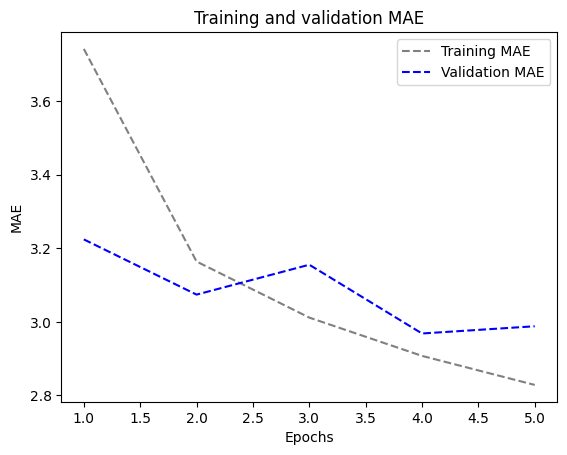

In [18]:
import matplotlib.pyplot as plt
loss1D = history1D.history["mae"]
validation_loss1D = history1D.history["val_mae"]

epochs = range(1, len(loss1D) + 1)
plt.figure()
plt.plot(epochs, loss1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Convolutional models appear to perform worse than dense models or simple heuristic methods. This could be attributed to the following reasons:**

Weather data does not meet the translation invariance assumption; the sequence of information is vital. When predicting the temperature for the next day, recent historical data is much more relevant than data from several days earlier. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.

**A Basic RNN:**

1. An RNN layer that can manage sequences of varying lengths.

In [19]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

models_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
models_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = models_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {models_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 84s 100ms/step - loss: 138.7882 - mae: 9.6895 - val_loss: 143.9583 - val_mae: 9.8935
Epoch 2/5
819/819 [==============================] - 81s 98ms/step - loss: 136.3302 - mae: 9.5539 - val_loss: 143.7089 - val_mae: 9.8673
Epoch 3/5
819/819 [==============================] - 80s 98ms/step - loss: 136.2309 - mae: 9.5442 - val_loss: 143.5716 - val_mae: 9.8537
Epoch 4/5
819/819 [==============================] - 83s 101ms/step - loss: 136.1764 - mae: 9.5387 - val_loss: 143.5915 - val_mae: 9.8533
Epoch 5/5
405/405 [==============================] - 22s 51ms/step - loss: 151.3586 - mae: 9.9262
Test MAE: 9.93


**2.Simple RNN - Stacking RNN layers**

**# Define a Simple RNN model with three layers, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, fit the model for 5 epochs with training and validation data, and evaluate the test MAE of the loaded model.**

In [20]:
the_features2 = 14
steps = 120
inpu2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(inpu2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
outpu2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(inpu2, outpu2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 165s 199ms/step - loss: 136.8451 - mae: 9.5675 - val_loss: 143.5800 - val_mae: 9.8593
Epoch 2/5
819/819 [==============================] - 168s 205ms/step - loss: 135.9415 - mae: 9.5124 - val_loss: 143.4388 - val_mae: 9.8389
Epoch 3/5
819/819 [==============================] - 159s 194ms/step - loss: 135.8900 - mae: 9.5056 - val_loss: 143.4372 - val_mae: 9.8383
Epoch 4/5
819/819 [==============================] - 145s 177ms/step - loss: 135.8582 - mae: 9.5010 - val_loss: 143.4540 - val_mae: 9.8392
Epoch 5/5
405/405 [==============================] - 30s 72ms/step - loss: 151.1845 - mae: 9.9165
Test MAE: 9.92


**Simple GRU (Gated Recurrent Unit)**

**# Define a GRU model with a single GRU layer followed by a dense output layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, fit the model for 5 epochs with training and validation data, and evaluate the test MAE of the loaded model.**

In [21]:
inputs_GRU = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 122s 146ms/step - loss: 43.4258 - mae: 4.7908 - val_loss: 12.9489 - val_mae: 2.7008
Epoch 2/5
819/819 [==============================] - 121s 147ms/step - loss: 10.6329 - mae: 2.5302 - val_loss: 9.6363 - val_mae: 2.3902
Epoch 3/5
819/819 [==============================] - 120s 147ms/step - loss: 9.4462 - mae: 2.3948 - val_loss: 9.6747 - val_mae: 2.3848
Epoch 4/5
819/819 [==============================] - 121s 148ms/step - loss: 9.1160 - mae: 2.3498 - val_loss: 9.6171 - val_mae: 2.3751
Epoch 5/5
405/405 [==============================] - 27s 64ms/step - loss: 10.2789 - mae: 2.5238
Test MAE: 2.52


**# Plot the training and validation Mean Absolute Error (MAE) over epochs to visualize the performance of the GRU model.**

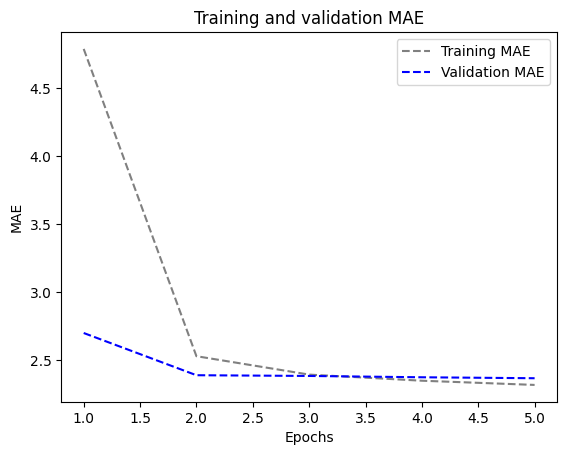

In [22]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**LSTM(Long Short-Term Memory )**

**1.LSTM-Simple**

**# Define an LSTM model with a single LSTM layer followed by a dense output layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [23]:
inputs_LSTMS = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 121s 144ms/step - loss: 43.2270 - mae: 4.8107 - val_loss: 13.6952 - val_mae: 2.7966
Epoch 2/5
819/819 [==============================] - 119s 145ms/step - loss: 11.2756 - mae: 2.6006 - val_loss: 9.6792 - val_mae: 2.4045
Epoch 3/5
819/819 [==============================] - 120s 146ms/step - loss: 9.7742 - mae: 2.4366 - val_loss: 9.6108 - val_mae: 2.3893
Epoch 4/5
819/819 [==============================] - 122s 148ms/step - loss: 9.2040 - mae: 2.3629 - val_loss: 9.7246 - val_mae: 2.4058
Epoch 5/5
819/819 [==============================] - 118s 144ms/step - loss: 8.7738 - mae: 2.3068 - val_loss: 9.7104 - val_mae: 2.4185


**# Load the trained LSTM model and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [24]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 28s 67ms/step - loss: 10.7758 - mae: 2.5690
Test MAE: 2.57


**# Visualize the training and validation Mean Absolute Error (MAE) over epochs using a line plot to assess the performance of the LSTM model.**

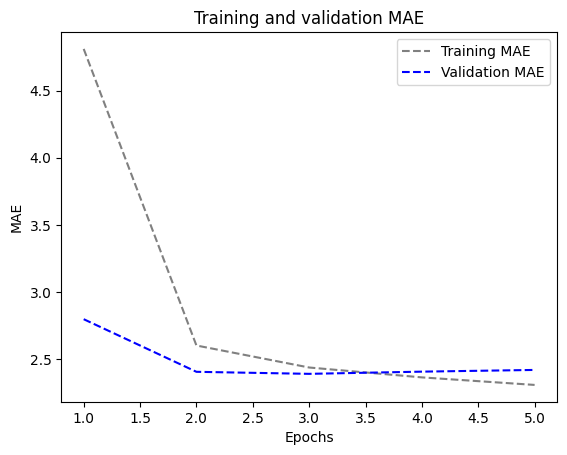

In [25]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**2.LSTM - dropout Regularization**

**# Define an LSTM model with recurrent dropout and an additional dropout layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [26]:
input_LSTMR = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 206s 248ms/step - loss: 55.0036 - mae: 5.5557 - val_loss: 15.5149 - val_mae: 2.9594
Epoch 2/5
819/819 [==============================] - 189s 230ms/step - loss: 20.5649 - mae: 3.4855 - val_loss: 10.3587 - val_mae: 2.5026
Epoch 3/5
819/819 [==============================] - 184s 224ms/step - loss: 18.4034 - mae: 3.2986 - val_loss: 9.7857 - val_mae: 2.4437
Epoch 4/5
819/819 [==============================] - 184s 224ms/step - loss: 17.5618 - mae: 3.2226 - val_loss: 9.8811 - val_mae: 2.4617
Epoch 5/5
819/819 [==============================] - 200s 244ms/step - loss: 16.9081 - mae: 3.1613 - val_loss: 9.7652 - val_mae: 2.4492


**# Load the trained LSTM model with dropout and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [27]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 29s 71ms/step - loss: 11.0419 - mae: 2.6011
Test MAE: 2.60


**# Plot the training and validation Mean Absolute Error (MAE) over epochs to evaluate the performance of the LSTM model with dropout.**

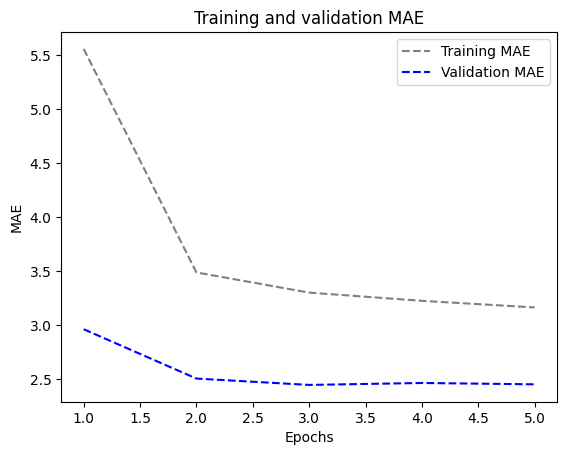

In [28]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**3.LSTM - Stacked setup with 16 units**

**# Define a stacked LSTM model with two LSTM layers and a dense output layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [29]:
input_16 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_16)
e = layers.LSTM(16)(e)
output_16 = layers.Dense(1)(e)
model_16 = keras.Model(input_16, output_16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 198s 237ms/step - loss: 41.8539 - mae: 4.6881 - val_loss: 13.1537 - val_mae: 2.7478
Epoch 2/5
819/819 [==============================] - 196s 239ms/step - loss: 10.1233 - mae: 2.4663 - val_loss: 9.9201 - val_mae: 2.4384
Epoch 3/5
819/819 [==============================] - 199s 243ms/step - loss: 8.6064 - mae: 2.2919 - val_loss: 9.9689 - val_mae: 2.4593
Epoch 4/5
819/819 [==============================] - 194s 237ms/step - loss: 7.9530 - mae: 2.2007 - val_loss: 9.9539 - val_mae: 2.4515
Epoch 5/5
819/819 [==============================] - 195s 238ms/step - loss: 7.4084 - mae: 2.1235 - val_loss: 10.3902 - val_mae: 2.5096


**# Load the trained stacked LSTM model and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [30]:
model_16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 40s 96ms/step - loss: 11.1248 - mae: 2.6137
Test MAE: 2.61


**# Visualize the training and validation Mean Absolute Error (MAE) over epochs to assess the performance of the stacked LSTM model.**

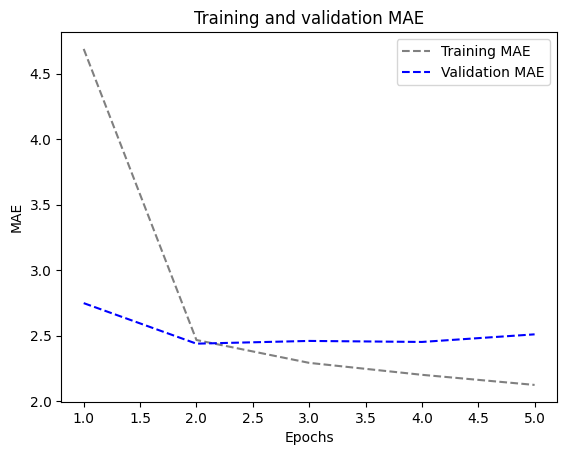

In [31]:
import matplotlib.pyplot as plt
loss_16 = history_16.history["mae"]
validation_loss_16 = history_16.history["val_mae"]

epochs = range(1, len(loss_16) + 1)
plt.figure()
plt.plot(epochs, loss_16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**4.LSTM - Stacked setup with 32 units**

**# Define a stacked LSTM model with two LSTM layers, each with 32 units, and a dense output layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [32]:
input_32 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_32)
f = layers.LSTM(32)(f)
output_32 = layers.Dense(1)(f)
model_32 = keras.Model(input_32, output_32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_32.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 318s 383ms/step - loss: 19.3505 - mae: 3.1607 - val_loss: 9.7593 - val_mae: 2.4392
Epoch 2/5
819/819 [==============================] - 287s 350ms/step - loss: 7.5829 - mae: 2.1500 - val_loss: 11.6533 - val_mae: 2.6639
Epoch 3/5
819/819 [==============================] - 314s 383ms/step - loss: 6.0945 - mae: 1.9237 - val_loss: 12.3078 - val_mae: 2.7439
Epoch 4/5
819/819 [==============================] - 311s 380ms/step - loss: 5.0528 - mae: 1.7465 - val_loss: 13.1386 - val_mae: 2.8378
Epoch 5/5
819/819 [==============================] - 283s 345ms/step - loss: 4.2531 - mae: 1.5983 - val_loss: 13.6807 - val_mae: 2.9039


**# Load the trained stacked LSTM model with 32 units and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [33]:
model_32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 57s 137ms/step - loss: 11.3868 - mae: 2.6352
Test MAE: 2.64


**# Plot the training and validation Mean Absolute Error (MAE) over epochs to evaluate the performance of the stacked LSTM model with 32 units.**

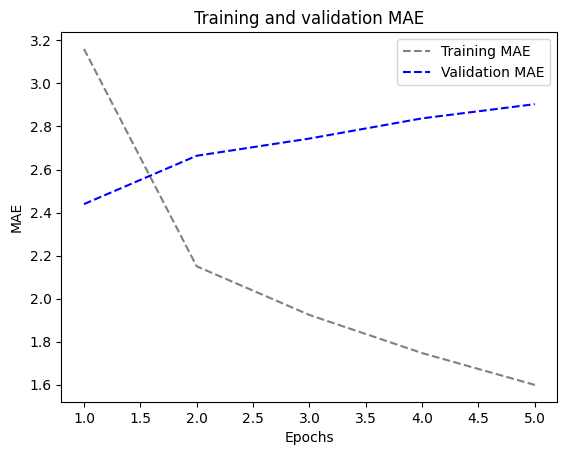

In [34]:
import matplotlib.pyplot as plt
loss_32 = history_32.history["mae"]
validation_loss_32 = history_32.history["val_mae"]

epochs = range(1, len(loss_32) + 1)
plt.figure()
plt.plot(epochs, loss_32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**5.LSTM - Stacked setup with 8 units**

**# Define a stacked LSTM model with two LSTM layers, each with 8 units, and a dense output layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [35]:
input_8u = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 167s 198ms/step - loss: 71.6695 - mae: 6.4940 - val_loss: 36.2953 - val_mae: 4.4773
Epoch 2/5
819/819 [==============================] - 164s 200ms/step - loss: 21.8485 - mae: 3.4515 - val_loss: 12.9873 - val_mae: 2.7021
Epoch 3/5
819/819 [==============================] - 165s 201ms/step - loss: 11.2928 - mae: 2.5927 - val_loss: 9.6835 - val_mae: 2.4096
Epoch 4/5
819/819 [==============================] - 173s 210ms/step - loss: 9.9578 - mae: 2.4580 - val_loss: 9.4873 - val_mae: 2.3898
Epoch 5/5
819/819 [==============================] - 164s 199ms/step - loss: 9.6523 - mae: 2.4221 - val_loss: 9.6762 - val_mae: 2.4008


**# Load the trained stacked LSTM model with 8 units and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [36]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 34s 81ms/step - loss: 10.7506 - mae: 2.5462
Test MAE: 2.55


**# Visualize the training and validation Mean Absolute Error (MAE) over epochs to assess the performance of the stacked LSTM model with 8 units.**

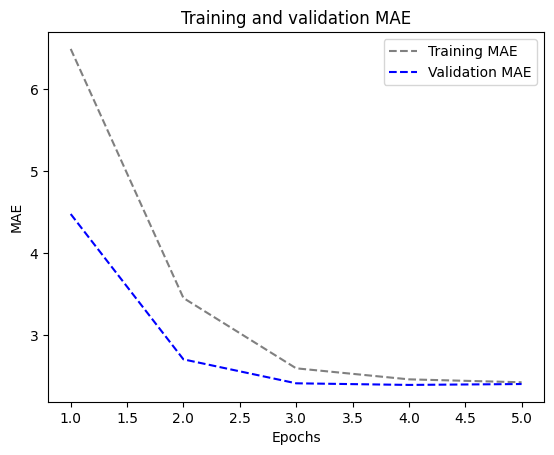

In [37]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**6.LSTM - dropout-regularized, stacked model**

**# Define a stacked LSTM model with two LSTM layers (8 units each) incorporating recurrent dropout and an additional dropout layer, set up model checkpointing, compile the model with RMSprop optimizer and MSE loss, and fit the model for 5 epochs with training and validation data.**

In [38]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 293s 350ms/step - loss: 67.2156 - mae: 6.2436 - val_loss: 29.0494 - val_mae: 3.9682
Epoch 2/5
819/819 [==============================] - 284s 346ms/step - loss: 29.8232 - mae: 4.0961 - val_loss: 13.2327 - val_mae: 2.7399
Epoch 3/5
819/819 [==============================] - 286s 349ms/step - loss: 24.2673 - mae: 3.7290 - val_loss: 10.8883 - val_mae: 2.5421
Epoch 4/5
819/819 [==============================] - 285s 348ms/step - loss: 22.3631 - mae: 3.5914 - val_loss: 10.6808 - val_mae: 2.5403
Epoch 5/5
819/819 [==============================] - 288s 352ms/step - loss: 21.1493 - mae: 3.4907 - val_loss: 10.2847 - val_mae: 2.4946


**# Load the trained stacked LSTM model with dropout and evaluate its performance on the testing data, printing the test Mean Absolute Error (MAE).**

In [39]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 38s 90ms/step - loss: 11.8805 - mae: 2.6785
Test MAE: 2.68


**# Plot the training and validation Mean Absolute Error (MAE) over epochs to evaluate the performance of the stacked LSTM model with dropout.**

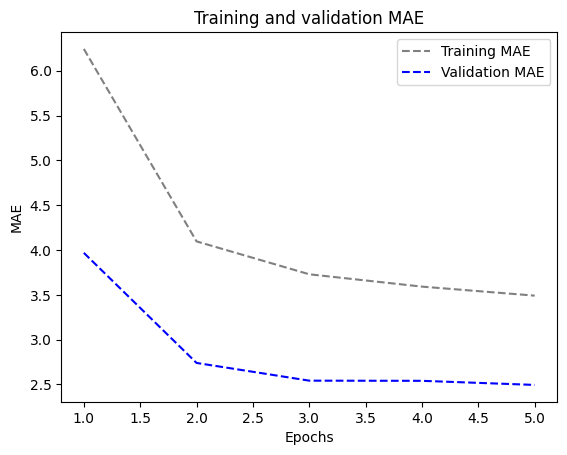

In [40]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

**# Define a bidirectional LSTM model, compile it, and train it on the training data while saving the best model based on validation loss.**

In [41]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 176s 209ms/step - loss: 26.2248 - mae: 3.6833 - val_loss: 10.9382 - val_mae: 2.5669
Epoch 2/5
819/819 [==============================] - 173s 211ms/step - loss: 9.5274 - mae: 2.4150 - val_loss: 9.7743 - val_mae: 2.4248
Epoch 3/5
819/819 [==============================] - 172s 210ms/step - loss: 8.7070 - mae: 2.3003 - val_loss: 9.9294 - val_mae: 2.4553
Epoch 4/5
819/819 [==============================] - 170s 208ms/step - loss: 8.1897 - mae: 2.2289 - val_loss: 10.0441 - val_mae: 2.4728
Epoch 5/5
819/819 [==============================] - 170s 207ms/step - loss: 7.8105 - mae: 2.1750 - val_loss: 10.0021 - val_mae: 2.4717


**# Load the best bidirectional LSTM model and evaluate its performance on the testing data, displaying the Mean Absolute Error (MAE).**

In [42]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 36s 86ms/step - loss: 10.1887 - mae: 2.5036
Test MAE: 2.50


**# Plot the training and validation Mean Absolute Error (MAE) over the epochs for the bidirectional LSTM model.**

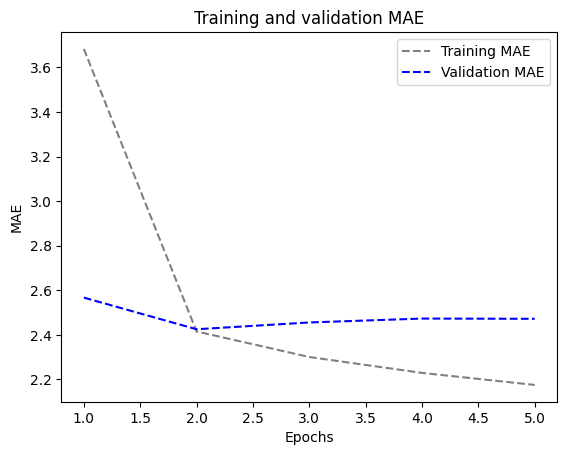

In [43]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

**# Build and train a model combining convolutional and LSTM layers to predict the target variable from the input data.**

In [44]:
input_final = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 131s 156ms/step - loss: 50.5608 - mae: 5.3218 - val_loss: 27.5972 - val_mae: 4.1195
Epoch 2/5
819/819 [==============================] - 128s 156ms/step - loss: 17.6315 - mae: 3.2387 - val_loss: 20.7467 - val_mae: 3.5998
Epoch 3/5
819/819 [==============================] - 127s 154ms/step - loss: 14.4251 - mae: 2.9436 - val_loss: 25.2478 - val_mae: 4.0520
Epoch 4/5
819/819 [==============================] - 129s 157ms/step - loss: 12.9324 - mae: 2.7843 - val_loss: 20.9449 - val_mae: 3.6135
Epoch 5/5
819/819 [==============================] - 127s 155ms/step - loss: 11.7593 - mae: 2.6476 - val_loss: 22.4572 - val_mae: 3.7668


**# Load the trained Conv-LSTM model and evaluate its performance on the testing data to obtain the Test MAE.**

In [45]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 27s 65ms/step - loss: 23.2409 - mae: 3.8456
Test MAE: 3.85


**# Plot the training and validation MAE over epochs to visualize the model's performance during training.**

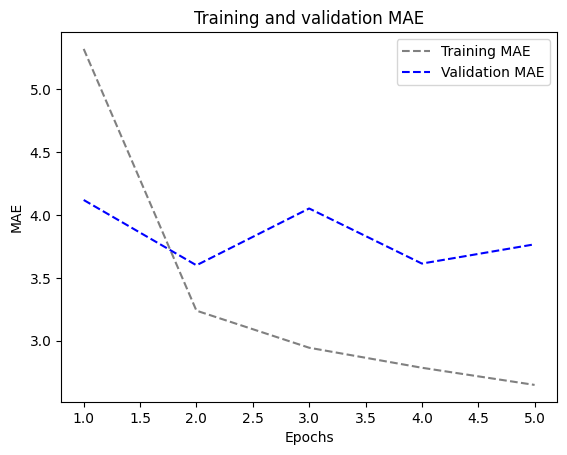

In [46]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Here are the details of the models developed:

- A common-sense, non-machine-learning baseline.
- A fundamental machine-learning model.
- A 1D convolutional model.
- A Simple RNN layer capable of handling sequences of varying lengths.
- A stacked configuration of Simple RNN layers.
- A Simple Gated Recurrent Unit (GRU).
- A basic LSTM (Long Short-Term Memory) model.
- An LSTM model with dropout regularization.
- A stacked model setup featuring 16 units.
- A stacked model configuration with 32 units.
- A stacked model structure with 8 units.
- A dropout-regularized, stacked LSTM model.
- A Bidirectional LSTM model.
- A combination of 1D Convolutional Networks and LSTM.

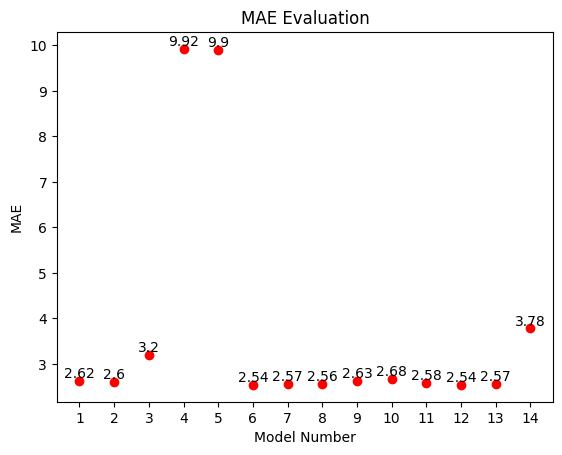

In [47]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
